Very simple object localization practice

Data is from [https://datasets.bifrost.ai/info/422](https://datasets.bifrost.ai/info/422)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

!tar - xvf "/content/drive/MyDrive/Colab Notebooks/annotations.tar.gz" - C / content
!tar - xvf "/content/drive/MyDrive/Colab Notebooks/images.tar.gz" - C / content


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Config

In [12]:
import tensorflow.keras as keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy
from PIL import Image, ImageDraw
import re
import os
import random

DATA_ROOT_DIR = '/content/'
WIDTH = 224
HEIGHT = 224
SEED = 2021

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
numpy.random.seed(SEED)
tf.random.set_seed(SEED)


# Load data

In [13]:
filenameList = []
xListRaw = []  
locListRaw = []   # (left_x, top_y, right_x, bottom_y)
labelList = []
infoList = []

max_width = 0
max_height = 0
for file in os.listdir(DATA_ROOT_DIR + 'images'):
    # file = Abyssinian_1.jpg
    if file.endswith('jpg'):
        try:
            (label, num) = file.split('.')[0].split('_')
            with open('%sannotations/xmls/%s_%s.xml' % (DATA_ROOT_DIR, label, num), 'r') as f:
                content = f.read()
                sizeReg = re.compile(r'<width>(\d+)</width>.*<height>(\d+)</height>.*<depth>(\d+)</depth>')
                size = sizeReg.search(content)
                w, h, d = int(size.group(1)), int(size.group(2)), int(size.group(3))
                boxReg = re.compile(r'<xmin>(\d+)</xmin>.*<ymin>(\d+)</ymin>.*<xmax>(\d+)</xmax>.*<ymax>(\d+)</ymax>')
                box = boxReg.search(content)
                bounding = (int(box.group(1)), 
                            int(box.group(2)),
                            int(box.group(3)), 
                            int(box.group(4)))
                
                if w > max_width: max_width = w
                if h > max_height: max_height = h
                locListRaw.append(bounding)
            xListRaw.append(Image.open('%simages/%s' % (DATA_ROOT_DIR, file)))
            labelList.append(label)
        except Exception as e:
            continue

print(max_width, max_height)


1725 1600


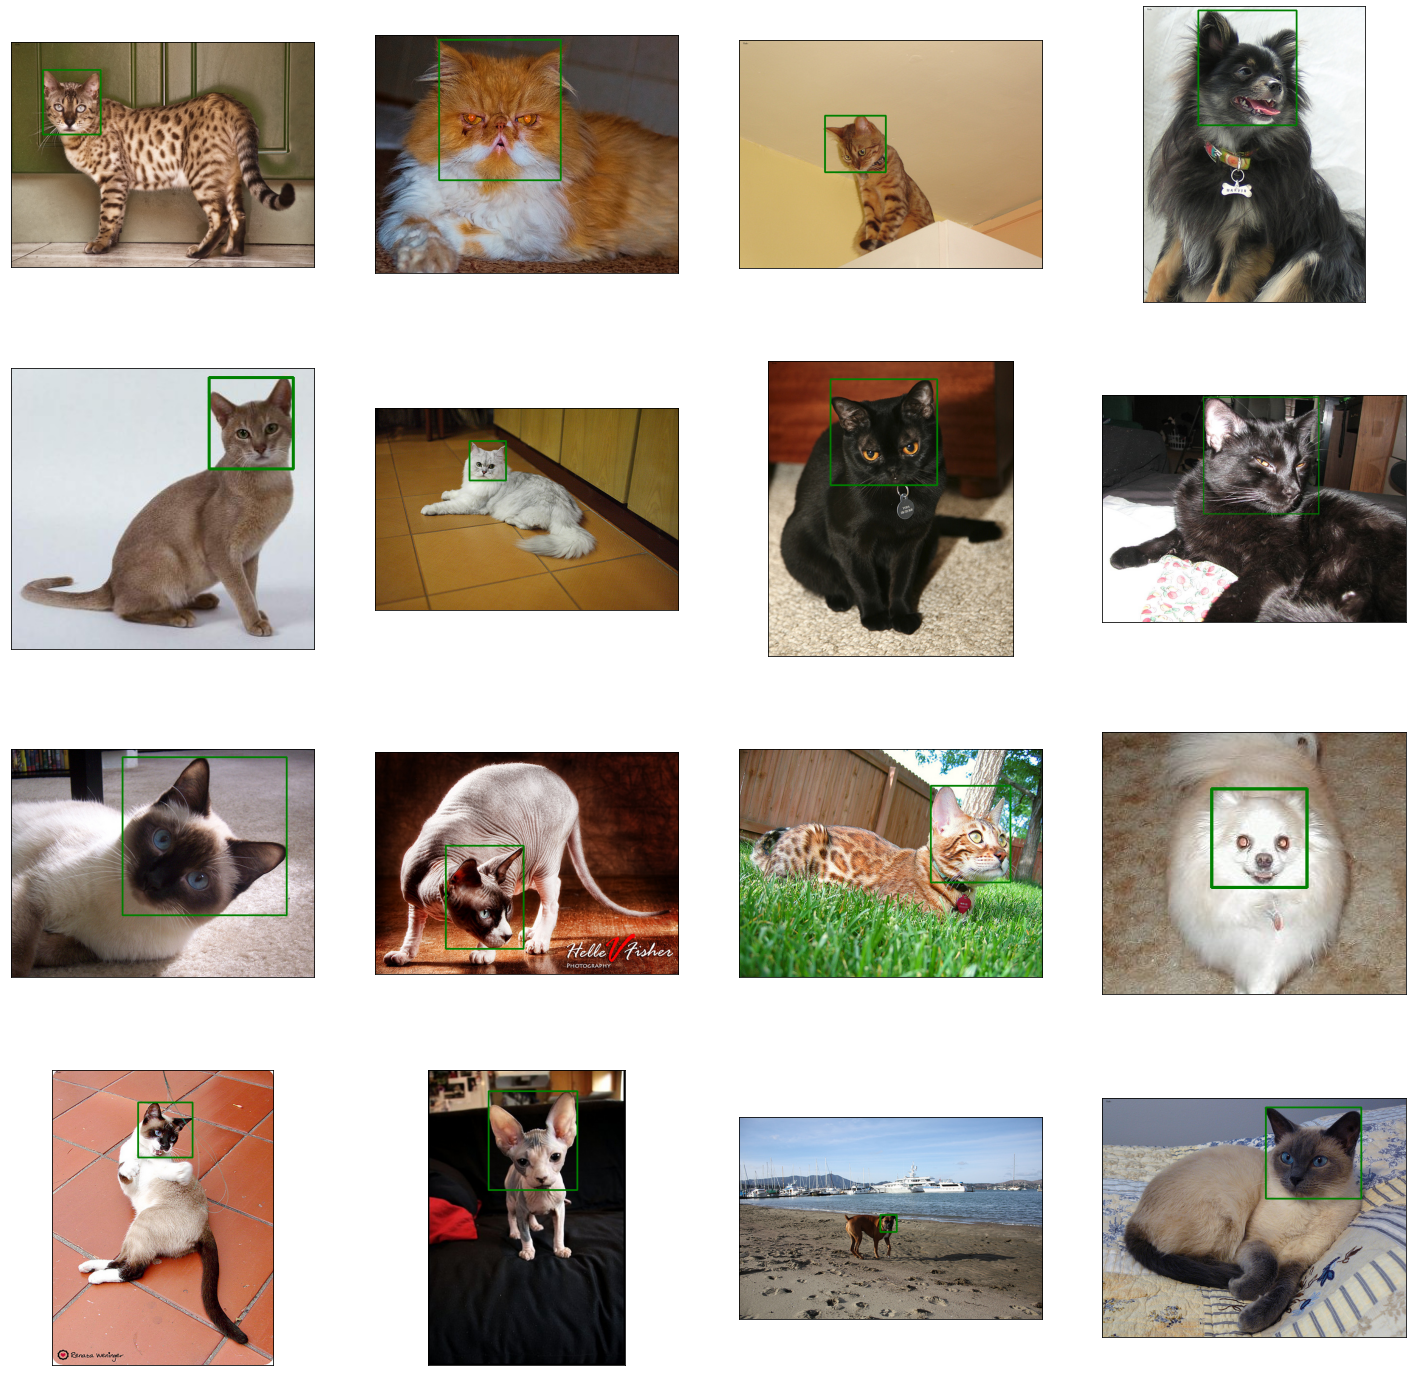

In [14]:
def show(imgList, locationList, i):
    plt.figure(figsize=(25, 25))
    for j in range(16):
        img = imgList[i+j]
        bounding = locationList[i+j]
        tmp = Image.fromarray(img) if type(img) == numpy.ndarray else img.copy()
        draw = ImageDraw.Draw(tmp)
        draw.line([(bounding[0], bounding[1]), 
                    (bounding[2], bounding[1]),
                    (bounding[2], bounding[3]),
                    (bounding[0], bounding[3]),
                   (bounding[0], bounding[1])], fill='green', width=3)
        plt.subplot(4, 4, j+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(tmp)

    plt.show()
    plt.close()

show(xListRaw, locListRaw, 0)


## Reshape Image & convert xList, yList to nparray

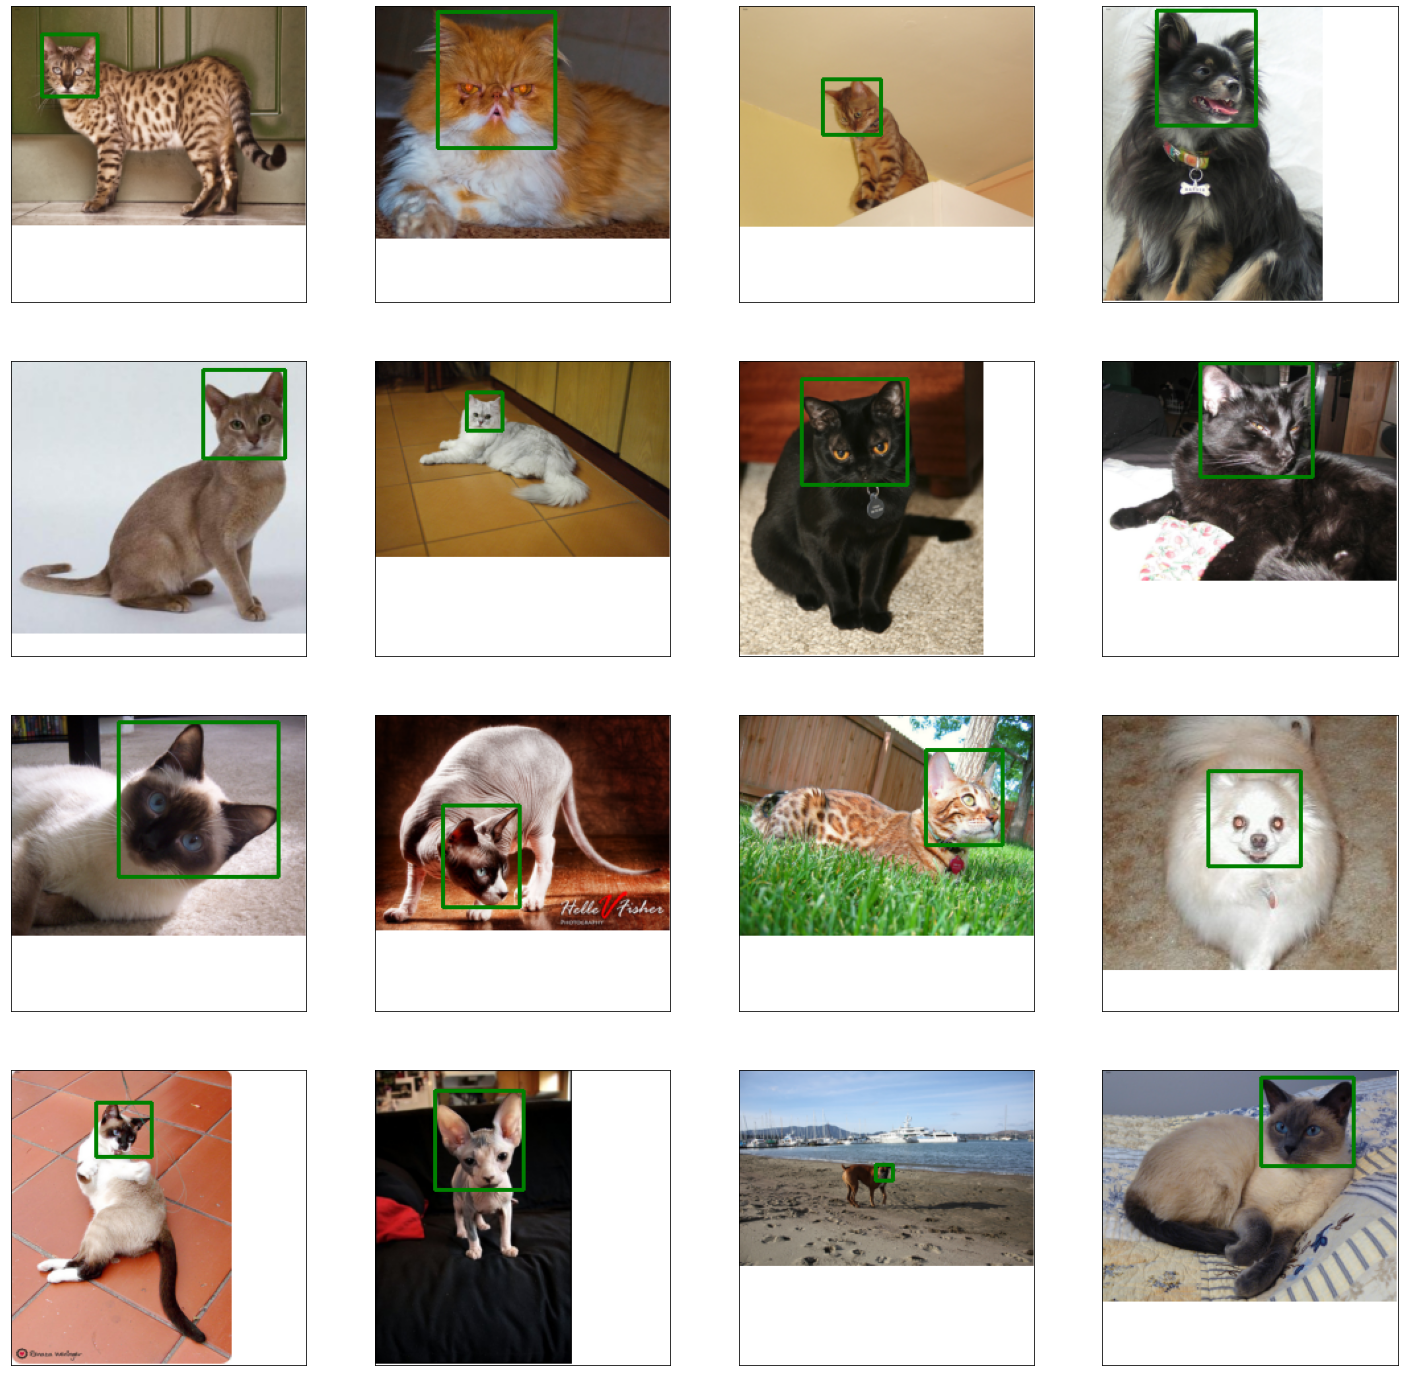

In [16]:
# reshape() reshpae image and recaculate the bounding box
def reshpae(img, bounding, target_w, target_h):
    i = Image.new("RGB", (target_w, target_h), color=(255, 255, 255))
    w, h = img.size
    if w > target_w or h > target_h:
        ratio = w/target_w if w/target_w > h/target_h else h/target_h
        tmp = img.copy().resize((int(w//ratio), int(h//ratio)),
                         resample=Image.BILINEAR)
        bounding = (int(bounding[0] // ratio),
                    int(bounding[1] // ratio),
                    int(bounding[2] // ratio),
                    int(bounding[3] // ratio))
        i.paste(tmp)
    else:
        i.paste(img)  # , box=None, mask=None
    return i, bounding

xList = []
yList = []
for index in range(len(xListRaw)):
    x, y = reshpae(xListRaw[index], locListRaw[index], WIDTH, HEIGHT)
    xList.append(numpy.asarray(x))
    yList.append(y)

show(xList, yList, 0)


In [17]:
from sklearn.model_selection import train_test_split

xList = numpy.asarray(xList) / 255.0
yList = numpy.asarray(yList) / WIDTH
middle = int(xList.shape[0] * 0.8)

xTrain, xTest, yTrain, yTest = train_test_split(
    xList, yList, test_size=0.2, random_state=SEED, shuffle=True)


# Build Model

In [23]:
def myModel():
    m = keras.Sequential()
    #m.add(keras.applications.vgg16.VGG16(input_shape=(HEIGHT, WIDTH, 3)))
    m.add(keras.layers.Conv2D(32, (3, 3), input_shape=(HEIGHT, WIDTH, 3)))
    m.add(keras.layers.Conv2D(64, (5, 5)))
    m.add(keras.layers.BatchNormalization())
    m.add(keras.layers.ReLU())
    m.add(keras.layers.MaxPool2D(pool_size=(2, 2)))

    m.add(keras.layers.Conv2D(128, (5, 5)))
    m.add(keras.layers.Conv2D(160, (7, 7)))
    m.add(keras.layers.BatchNormalization())
    m.add(keras.layers.ReLU())
    m.add(keras.layers.MaxPool2D(pool_size=(2, 2)))

    m.add(keras.layers.Conv2D(192, (3, 3)))
    m.add(keras.layers.Conv2D(224, (5, 5)))
    m.add(keras.layers.BatchNormalization())
    m.add(keras.layers.ReLU())
    m.add(keras.layers.MaxPool2D(pool_size=(2, 2)))

    m.add(keras.layers.GlobalAveragePooling2D())
    m.add(keras.layers.Dense(64, activation='relu'))
    m.add(keras.layers.Dense(4, activation='sigmoid'))
    return m


In [24]:
m = myModel()
m.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 218, 218, 64)      51264     
_________________________________________________________________
batch_normalization_3 (Batch (None, 218, 218, 64)      256       
_________________________________________________________________
re_lu_3 (ReLU)               (None, 218, 218, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 109, 109, 64)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 105, 105, 128)     204928    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 99, 99, 160)      

In [25]:
import gc
gc.collect()

m.compile(optimizer='adam', metrics=['acc'], loss='mean_squared_error')
history = m.fit(xTrain, yTrain, epochs=15, validation_split=0.2, batch_size=50)

test_loss, test_acc = m.evaluate(xTest,  yTest, verbose=2)
print(test_loss, test_acc)


Epoch 1/15
23/23 [==============================] - 81s 2s/step - loss: 0.0286 - acc: 0.7770 - val_loss: 0.1139 - val_acc: 0.7431
Epoch 2/15
23/23 [==============================] - 26s 1s/step - loss: 0.0168 - acc: 0.8380 - val_loss: 0.1874 - val_acc: 0.4618
Epoch 3/15
23/23 [==============================] - 26s 1s/step - loss: 0.0165 - acc: 0.8380 - val_loss: 0.1395 - val_acc: 0.6840
Epoch 4/15
23/23 [==============================] - 26s 1s/step - loss: 0.0158 - acc: 0.8476 - val_loss: 0.0513 - val_acc: 0.8438
Epoch 5/15
23/23 [==============================] - 26s 1s/step - loss: 0.0158 - acc: 0.8371 - val_loss: 0.0567 - val_acc: 0.5799
Epoch 6/15
23/23 [==============================] - 26s 1s/step - loss: 0.0159 - acc: 0.8406 - val_loss: 0.0760 - val_acc: 0.3333
Epoch 7/15
23/23 [==============================] - 26s 1s/step - loss: 0.0161 - acc: 0.8179 - val_loss: 0.0510 - val_acc: 0.8368
Epoch 8/15
23/23 [==============================] - 26s 1s/step - loss: 0.0158 - acc: 0.84

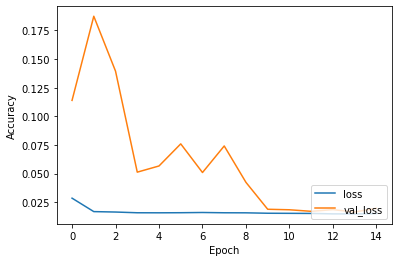

In [26]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

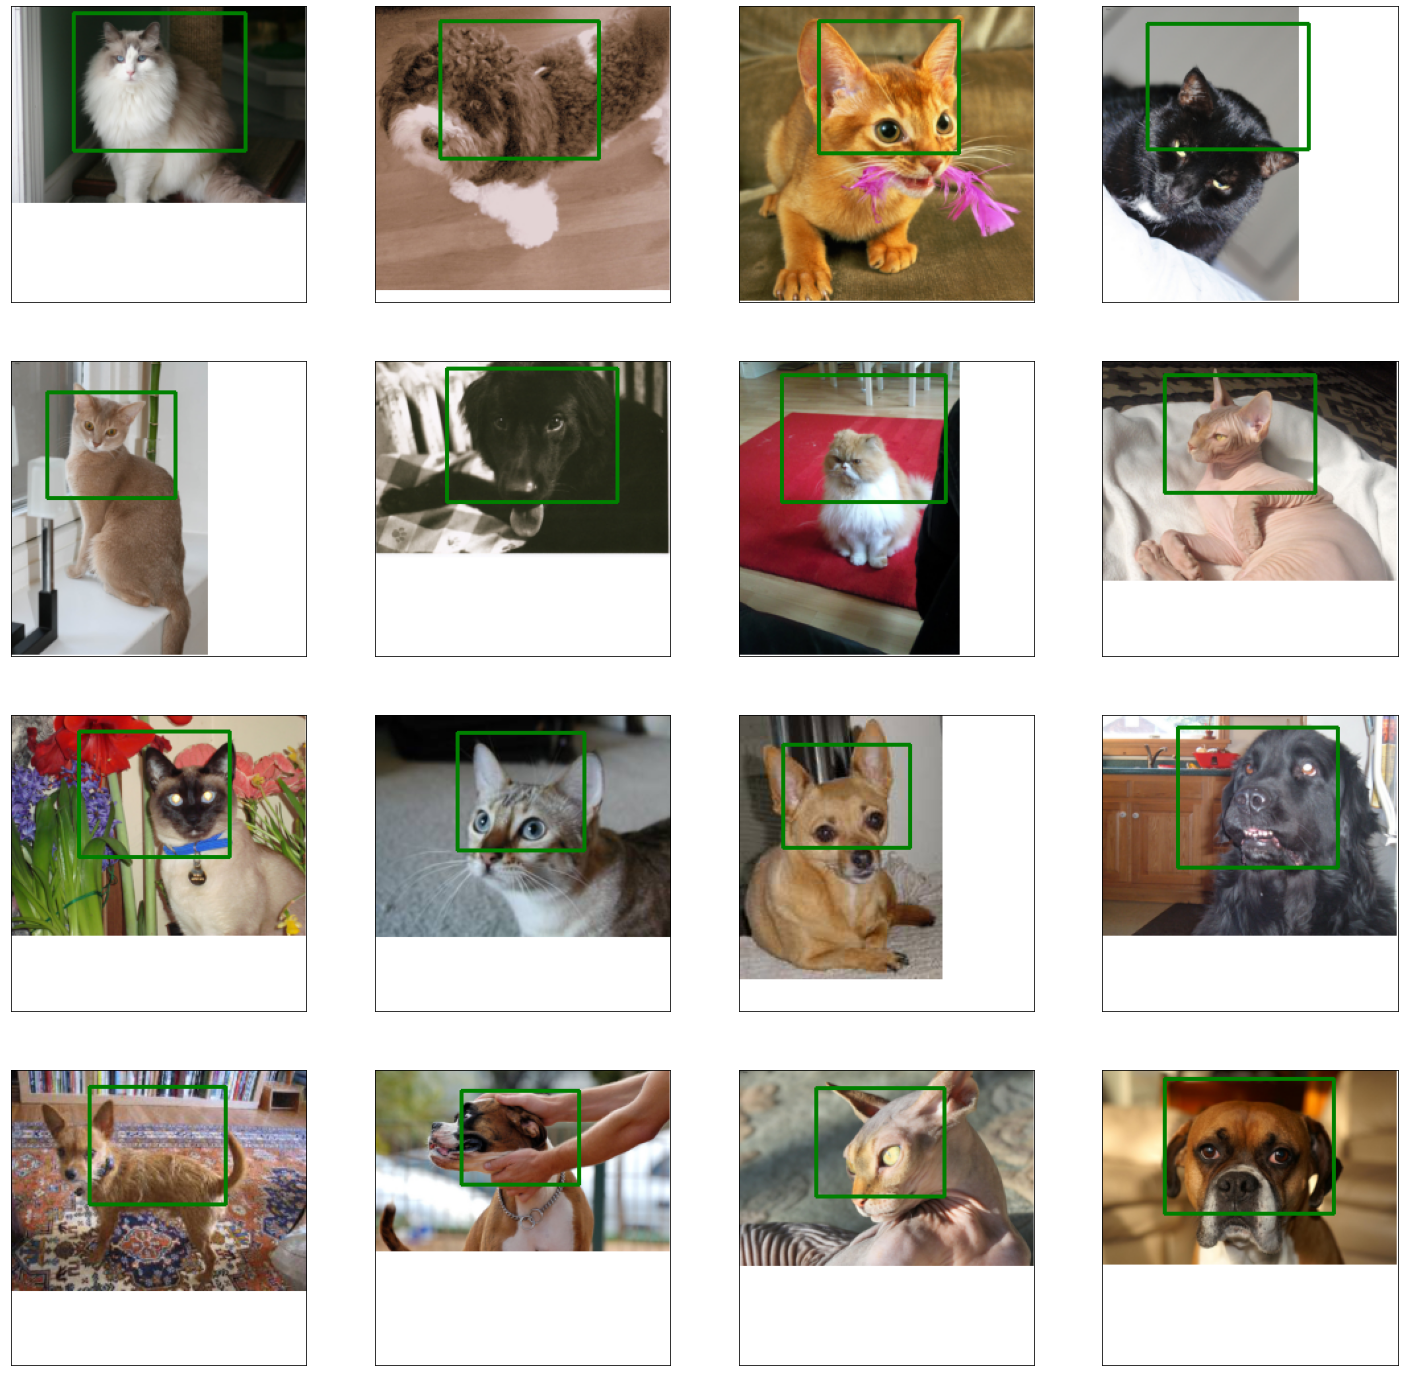

In [60]:
x = xTest[0:16]
predictTest = m.predict(x) * WIDTH
predictTest = numpy.asarray(predictTest, dtype='uint')
x = numpy.asarray(x * 255).astype(numpy.uint8)

show(x, predictTest, 0)